In [4]:
import numpy as np
import matplotlib.pyplot as plt

Klasse, um Daten zu laden:

In [5]:
# Copyright (c) 2023, Hannes Ebeling
# All rights reserved.

# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

class EPHIN:
    def __init__(self,path,columns=None,labels=['year','month','dom','doy','msod','coincidence','segment_A','segment_B','priority_bit','A','full_A','B','full_B','C','full_C','D','D_full','E','E_full','status','ring','coincidence_counter','num_pha_lines','overflow_flag']):
        '''Lade EPHIN-Daten unter angegebenem Pfad. Berechne zusätzlich noch die Gesamtenergie. Cloumns und labels brauchen die gleiche Länge. Usecols beginnt mit Index 0.'''
        self.data = {}
        self.labels = labels
        self.columns = columns
        if self.columns == None:
            ayuda = np.loadtxt(path).T
        else:
            ayuda = np.loadtxt(path,usecols=self.columns).T

        for i,label in enumerate(self.labels):
            self.data[label] = ayuda[i]
        self.data['E_ges'] = self.data['A'] + self.data['B'] + self.data['C'] + self.data['D'] + self.data['E']

    def append(self,path):
        '''Hängt neue Datei jeweils an die Enden der Arrays an.'''
        if self.columns == None:
            ayuda = np.loadtxt(path).T
        else:
            ayuda = np.loadtxt(path,usecols=self.columns).T
        E_ges_ayuda = np.zeros(len(ayuda[0]))
        for i,label in enumerate(self.labels):
            self.data[label] = np.append(self.data[label],ayuda[i])
            if label == 'A' or label == 'B' or label == 'C' or label =='D' or label == 'E':
                E_ges_ayuda = E_ges_ayuda + ayuda[i]
        self.data['E_ges'] = np.append(self.data['E_ges'], E_ges_ayuda)

    def calculate_PIN(self,thin_det):
        '''PIN in MeV (Umrechnung von keV in MeV)'''
        self.data['PIN'] = self.data[thin_det] * self.data['E_ges'] * 1e-6
        return self.data['PIN']

    def separation(self,hist_data,range1,range2,label1,label2,thin_det='C',xrange=(0,5.25),plot_range=None,bins=100):
        '''Range gibt mir den Bereich der PINS, In pin stehen die entsprechenden Werte der Histogram-Grenzen.'''
        ax = plt.subplots()
        histogram = plt.hist(hist_data,bins=bins,range=xrange)
        if plot_range != None:
            plt.xlim(plot_range)

        # Separation
        indices1 = []
        indices2 = []
        for i, current_pin in enumerate(np.log10(self.data['PIN'])):
            if range1[0] <= current_pin < range1[1]:
                indices1.append(i)
            if range2[0] <= current_pin < range2[1]:
                indices2.append(i)

        # Grenzen plotten
        plt.axvline(range1[0],color='firebrick',label=label1)
        plt.axvline(range1[1],color='firebrick')
        plt.axvline(range2[0],color='orange',label=label2)
        plt.axvline(range2[1],color='orange')

        plt.yscale('log')
        plt.xlabel('$\log_{10}(PIN)$')
        plt.ylabel('counts')
        plt.legend()
        plt.title('Verteilung der PIN')

        return indices1, indices2

    def energy_distribution(self,indices,label,xrange,normierung=1):
        return plt.hist(self.data['E_ges'][indices]/normierung,histtype='step',range=xrange,bins=50,density=True,label=label)


In [6]:
data = EPHIN('quiet-time/eph96001.l3pha',columns=(0,1,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,23),labels=['year','month','doy','coincidence','segment_A','segment_B','priority_bit','A','full_A','B','full_B','C','full_C','D','D_full','E','E_full','overflow_flag'])
for i in range(2,10):
    data.append('quiet-time/eph9600'+str(i)+'.l3pha')
for i in range(10,28):
    data.append('quiet-time/eph960'+str(i)+'.l3pha')

Nutze C als dünnen Detektor. Koinzidenz 7 sind Protonen die in Detektor A, B, C, D und E ansprechen. Koinzidenz 11 ist Helium in den entsprechenden Detektoren.  
Nochmal einschränken detB = detA = 0 für bessere Ergebnisse (gerade durchgehende Teilchen). Nachteil: Fehlende Statistik.

[False False False ... False False False]
[False False False ... False False False]


Text(0.5, 1.0, 'Protonen und Helium in den ersten 27 Tagen des Jahres 1996')

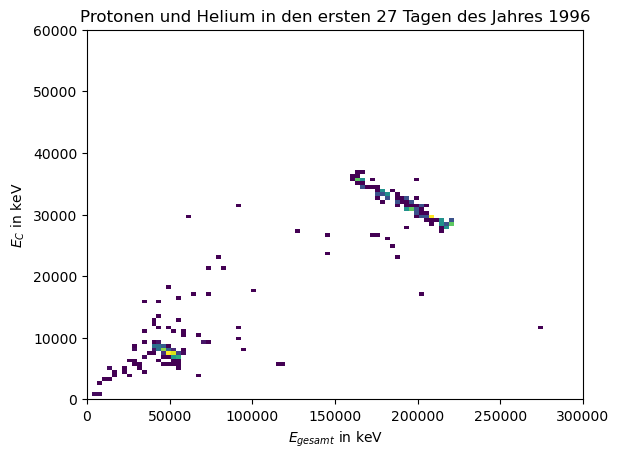

In [10]:
coincidence7 = data.data['coincidence'] == 7.0
coincidence11 = data.data['coincidence'] == 11.0 
detA = data.data['segment_A'] == 0
detB = data.data['segment_B'] == 0

print(detA)

det0 = np.logical_and(detA,detB)
print(det0)

# Einschränkung auf detA = detB = 0 nur mit mehr Daten sinnvoll
coincidence7 = np.logical_and(coincidence7,det0)
coincidence11 = np.logical_and(coincidence11,det0)

ax = plt.subplots()

xrange = [[0,3e5],[0,6e4]]
bins = 100
cmin = 1e-3

plt.hist2d(data.data['E_ges'][coincidence7],data.data['C'][coincidence7],range=xrange,bins=bins,cmin=cmin)
plt.hist2d(data.data['E_ges'][coincidence11],data.data['C'][coincidence11],range=xrange,bins=bins,cmin=cmin)
#plt.ylim(0,10000)

plt.xlabel('$E_{gesamt}$ in keV')
plt.ylabel('$E_C$ in keV')
plt.title('Protonen und Helium in den ersten 27 Tagen des Jahres 1996')

Abfallender Bereich kommt aus Bethe-Bloch... Wie erklärt sich der steigende Bereich --> steckenbleibende Teilchen in C --> erzeugt Elektronen, die in D und E ansprechen!!!  
Im Folgenden Berechnung der $PIN = \frac{\textrm{d}E}{\textrm{d}x} \cdot E \approx mZ^2$ für Protonen und Helium:

C:\Users\ebel1\AppData\Local\Temp\ipykernel_23596\3777953586.py:50: RuntimeWarning: divide by zero encountered in log10
  for i, current_pin in enumerate(np.log10(self.data['PIN'])):


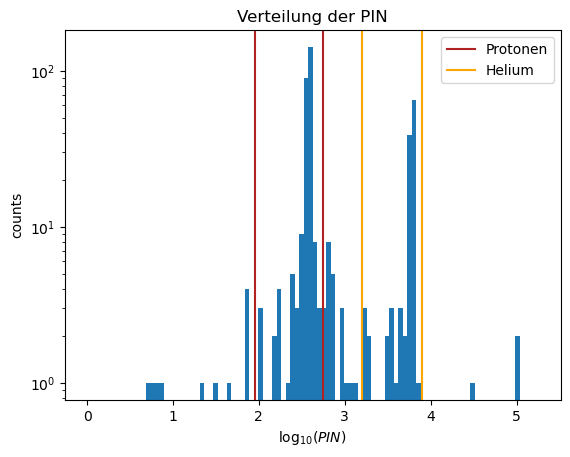

In [11]:
data.calculate_PIN('C')

p_in, he_in = data.separation(np.append(np.log10(data.data['PIN'][coincidence7]),np.log10(data.data['PIN'][coincidence11])),(1.95,2.75),(3.2,3.9),'Protonen','Helium',bins=100)

# ax = plt.subplots()
# plt.xlabel('Energie in keV')
# plt.ylabel('Verteilungsdichte')
# plt.title('Normierte Energieverteilung')

# data.energy_distribution(p_in,'Protonen',normierung=1)
# data.energy_distribution(he_in,'Helium',normierung=4)

plt.legend()

Energieverteilung für Helium-3 und Helium-4 sowie Wasserstoff und Deuterium:

C:\Users\ebel1\AppData\Local\Temp\ipykernel_23596\3777953586.py:50: RuntimeWarning: divide by zero encountered in log10
  for i, current_pin in enumerate(np.log10(self.data['PIN'])):


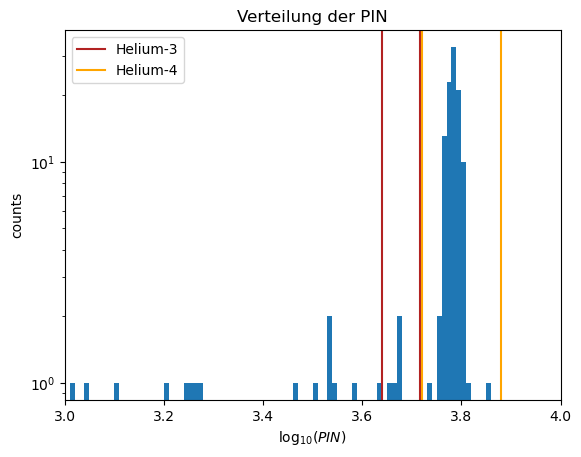

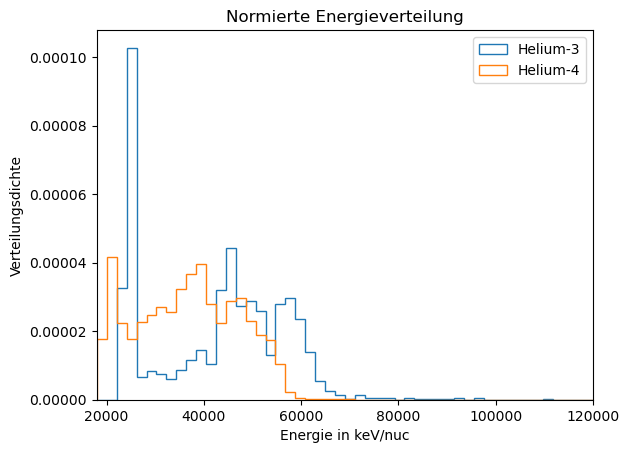

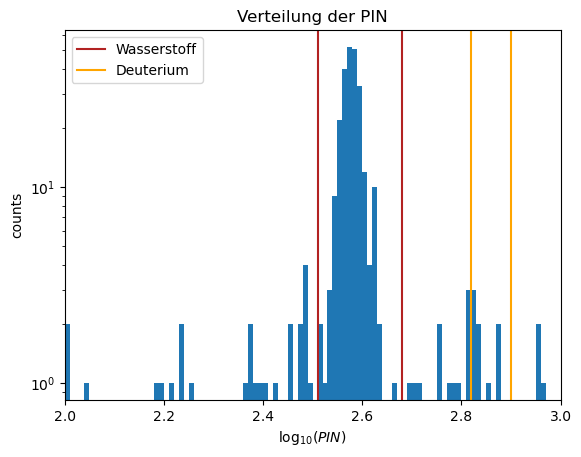

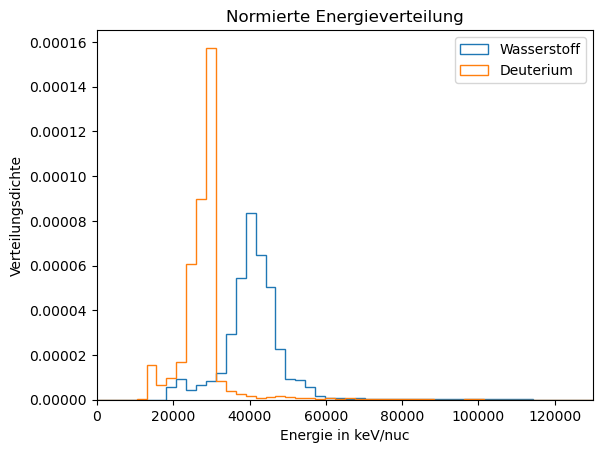

In [12]:
he3_in, he4_in = data.separation(np.append(np.log10(data.data['PIN'][coincidence7]),np.log10(data.data['PIN'][coincidence11])),(3.64,3.7175),(3.72,3.88),'Helium-3','Helium-4',xrange=(3.0,4.0),plot_range=(3.0,4.0),bins=100)

ax = plt.subplots()
plt.xlabel('Energie in keV/nuc')
plt.ylabel('Verteilungsdichte')
plt.title('Normierte Energieverteilung')

xrange = (0.18e5,1.2e5)
plt.xlim(xrange)

data.energy_distribution(he3_in,'Helium-3',xrange=xrange,normierung=3)
data.energy_distribution(he4_in,'Helium-4',xrange=xrange,normierung=4)

plt.legend()

hyd_in, deut_in = data.separation(np.append(np.log10(data.data['PIN'][coincidence7]),np.log10(data.data['PIN'][coincidence11])),(2.51,2.68),(2.82,2.9),'Wasserstoff','Deuterium',xrange=(2.0,3.0),plot_range=(2.0,3.0),bins=100)

ax = plt.subplots()
plt.xlabel('Energie in keV/nuc')
plt.ylabel('Verteilungsdichte')
plt.title('Normierte Energieverteilung')

xrange = (0,1.3e5)
plt.xlim(xrange)

data.energy_distribution(hyd_in,'Wasserstoff',xrange=xrange,normierung=1)
data.energy_distribution(deut_in,'Deuterium',xrange=xrange,normierung=2)

plt.legend()